# Overview

- EDA
- sample/feature selection
- baseline model
- validation
- submit

【基本の考え方】

- Private LB がテストデータで評価されるため、テストデータに基づいてクリーニング、特徴量選択、訓練データの選択、を行う。
- nb06 のデータセットを変えて公開されたデータセット wikipedia toxicity 版をつくる。

In [1]:
# Directories
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/wikipedia-toxicity/train.csv
/kaggle/input/jigsaw-toxic-severity-rating/sample_submission.csv
/kaggle/input/jigsaw-toxic-severity-rating/validation_data.csv
/kaggle/input/jigsaw-toxic-severity-rating/comments_to_score.csv


In [2]:
# Parameters
DEBUG_FLAG = False
VERSION = 'nb06'

SUBMISSION_PATH = '/kaggle/input/jigsaw-toxic-severity-rating/sample_submission.csv'
VALIDATION_DATA_PATH = '/kaggle/input/jigsaw-toxic-severity-rating/validation_data.csv'
COMMENTS_SCORE_PATH = '/kaggle/input/jigsaw-toxic-severity-rating/comments_to_score.csv'
WIKI_TRAIN_PATH = '/kaggle/input/wikipedia-toxicity/train.csv'

N_SPLITS = 5 if not DEBUG_FLAG else 2

In [3]:
# Modules
import re
import sys
import time

import datatable as dt
import nltk
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib_venn import venn3
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge, SGDClassifier, SGDRegressor
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB

sys.setrecursionlimit(5000)

In [4]:
# My functions
def read_df():
    valid = dt.fread(VALIDATION_DATA_PATH).to_pandas()
    test = dt.fread(COMMENTS_SCORE_PATH).to_pandas()
    submission = dt.fread(SUBMISSION_PATH).to_pandas()
    wiki = dt.fread(WIKI_TRAIN_PATH).to_pandas()
    
    if DEBUG_FLAG:
        valid = valid.sample(n=1000).reset_index(drop=True)
        test = test.sample(n=1000).reset_index(drop=True)
        wiki = wiki.sample(n=1000).reset_index(drop=True)
    
    return valid, test, submission, wiki

In [5]:
valid, test, submission, wiki = read_df()

print(f'valid shape: {valid.shape}')
print(f'test shape: {test.shape}')
print(f'submission shape: {submission.shape}')
print(f'wiki shape: {wiki.shape}')

valid shape: (30108, 3)
test shape: (7537, 2)
submission shape: (7537, 2)
wiki shape: (5000, 3)


In [6]:
display(valid.head())
display(test.head())
display(submission.head())
display(wiki.head())

,worker,less_toxic,more_toxic
0,313,This article sucks \n\nwoo woo wooooooo,WHAT!!!!!!!!?!?!!?!?!!?!?!?!?!!!!!!!!!!!!!!!!!...
1,188,"""And yes, people should recognize that but the...",Daphne Guinness \n\nTop of the mornin' my fav...
2,82,"Western Media?\n\nYup, because every crime in...","""Atom you don't believe actual photos of mastu..."
3,347,And you removed it! You numbskull! I don't car...,You seem to have sand in your vagina.\n\nMight...
4,539,smelly vagina \n\nBluerasberry why don't you ...,"hey \n\nway to support nazis, you racist"


,comment_id,text
0,114890,"""\n \n\nGjalexei, you asked about whether ther..."
1,732895,"Looks like be have an abuser , can you please ..."
2,1139051,I confess to having complete (and apparently b...
3,1434512,"""\n\nFreud's ideas are certainly much discusse..."
4,2084821,It is not just you. This is a laundry list of ...


,comment_id,score
0,114890,0.5
1,732895,0.5
2,1139051,0.5
3,1434512,0.5
4,2084821,0.5


,id,comment_text,toxic
0,e617e2489abe9bca,"""\r\n\r\n A barnstar for you! \r\n\r\n The De...",False
1,9250cf637294e09d,"""\r\n\r\nThis seems unbalanced. whatever I ha...",False
2,ce1aa4592d5240ca,"Marya Dzmitruk was born in Minsk, Belarus in M...",False
3,48105766ff7f075b,"""\r\n\r\nTalkback\r\n\r\n Dear Celestia... """,False
4,0543d4f82e5470b6,New Categories \r\n\r\nI honestly think that w...,False


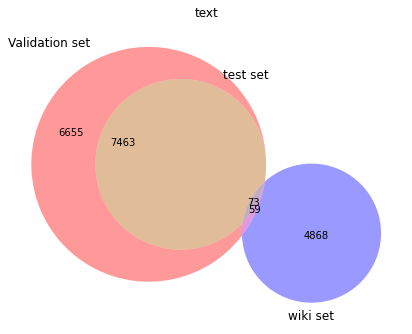

In [7]:
valid_unique_text = set(pd.concat([valid['less_toxic'], valid['more_toxic']]).unique())
test_unique_text = set(test['text'].unique())
wiki_unique_text = set(wiki['comment_text'].unique())

plt.figure(figsize=(6,6))
venn3(subsets=(valid_unique_text, test_unique_text, wiki_unique_text),
      set_labels=('Validation set', 'test set', 'wiki set'))
plt.title('text')
plt.tight_layout()
plt.show()

test は validation に含まれている。一方で test は wiki にほとんど含まれていない。アンサンブルに使うスコアをつくるのであれば、ないよりはよいという考え。

方針としては、特徴抽出して、adversarial validation により似ているサンプルセットを使って学習、予測という流れ。

In [8]:
# クリーニング関数
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None, whitelist=None):
    # clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    
    # remove numbers
    text = re.sub(r'[\d]', '', text)
            
    # Tokenize (convert from string to list)
    lst_text = text.split()
    
    # remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in lst_stopwords]
                
    # Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    # Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
    
    # white words list
    if whitelist is not None:
        lst_text = [word for word in lst_text if word in whitelist]
        
    # back to string from list
    text = ' '.join(lst_text)
    
    return text

In [9]:
%%time
stop_words = list(text.ENGLISH_STOP_WORDS)

# test のクリーニング
test['text_clean'] = test['text'].apply(lambda x: 
    utils_preprocess_text(x, flg_stemm=True, flg_lemm=True, lst_stopwords=stop_words, whitelist=None)
)

test_words = set(' '.join(test['text_clean']).split())
print(f'test_words size: {len(test_words)}')

test_words size: 23636
CPU times: user 9.12 s, sys: 158 ms, total: 9.27 s
Wall time: 9.29 s


In [10]:
%%time

# valid のクリーニング
valid_unique_text = pd.Series(pd.concat([valid['less_toxic'], valid['more_toxic']]).unique())
valid_unique_text_cleaned = valid_unique_text.apply(lambda x: 
    utils_preprocess_text(x, flg_stemm=True, flg_lemm=True, lst_stopwords=stop_words, whitelist=test_words)
)
valid_unique_text_dic = {text: cleaned_text for text, cleaned_text in zip(valid_unique_text, valid_unique_text_cleaned)}
valid['less_toxic_clean'] = valid['less_toxic'].map(valid_unique_text_dic)
valid['more_toxic_clean'] = valid['more_toxic'].map(valid_unique_text_dic)

# wiki のクリーニング
wiki = wiki.rename(columns={'comment_text': 'text'})
wiki['text_clean'] = wiki['text'].apply(lambda x: 
    utils_preprocess_text(x, flg_stemm=True, flg_lemm=True, lst_stopwords=stop_words, whitelist=test_words)
)

CPU times: user 19.3 s, sys: 11.1 ms, total: 19.3 s
Wall time: 19.3 s


In [11]:
display(valid[['less_toxic', 'less_toxic_clean']])
display(valid[['more_toxic', 'more_toxic_clean']])
display(test[['text', 'text_clean']])
display(wiki[['text', 'text_clean']])

,less_toxic,less_toxic_clean
0,This article sucks \n\nwoo woo wooooooo,articl suck woo woo wooooooo
1,"""And yes, people should recognize that but the...",ye peopl recogn usual dont object hear direct ...
2,"Western Media?\n\nYup, because every crime in...",western medium yup crime entir world caus west...
3,And you removed it! You numbskull! I don't car...,remov numbskul dont care say anymor life ahead...
4,smelly vagina \n\nBluerasberry why don't you ...,smelli vagina bluerasberri dont model cheesi b...
...,...,...
30103,I'm sorry. I'm not an admin. I will give you t...,im sorri im admin piec advic edit page away gu...
30104,I'm sorry. I'm not an admin. I will give you t...,im sorri im admin piec advic edit page away gu...
30105,"wow...\nare you out of your mind, how was my e...",wow mind edit talk page vandal simpli explain ...
30106,"wow...\nare you out of your mind, how was my e...",wow mind edit talk page vandal simpli explain ...


,more_toxic,more_toxic_clean
0,WHAT!!!!!!!!?!?!!?!?!!?!?!?!?!!!!!!!!!!!!!!!!!...,wher sexi pic gone main page
1,Daphne Guinness \n\nTop of the mornin' my fav...,daphn guin mornin favourit alien life form im ...
2,"""Atom you don't believe actual photos of mastu...",atom dont believ actual photo masturb sexual e...
3,You seem to have sand in your vagina.\n\nMight...,sand vagina want wash stink hole bitch
4,"hey \n\nway to support nazis, you racist",hey way support nazi racist
...,...,...
30103,get out my large penis,larg peni
30104,get out my large penis,larg peni
30105,Piss off you slant eyed-gook,piss slant eyedgook
30106,Piss off you slant eyed-gook,piss slant eyedgook


,text,text_clean
0,"""\n \n\nGjalexei, you asked about whether ther...",gjalexei ask antieditori polici call wikipedia...
1,"Looks like be have an abuser , can you please ...",look like abus look thank
2,I confess to having complete (and apparently b...,confess have complet appar bliss ignor jordan ...
3,"""\n\nFreud's ideas are certainly much discusse...",freud idea certainli discus today agre grappl ...
4,It is not just you. This is a laundry list of ...,just laundri list stupid alleg scoop godknowsw...
...,...,...
7532,"Go away, you annoying vandal.",away annoy vandal
7533,This user is a vandal.,user vandal
7534,""" \n\nSorry to sound like a pain, but one by f...",sorri sound like pain follow tad stalk honesti...
7535,Well it's pretty fucking irrelevant now I'm un...,pretti fuck irrelev im unblock aint


,text,text_clean
0,"""\r\n\r\n A barnstar for you! \r\n\r\n The De...",barnstar defend wiki barnstar like edit page l...
1,"""\r\n\r\nThis seems unbalanced. whatever I ha...",unbalanc said mathsci said far extrem unpleas ...
2,"Marya Dzmitruk was born in Minsk, Belarus in M...",born march mother born father born second chil...
3,"""\r\n\r\nTalkback\r\n\r\n Dear Celestia... """,talkback dear
4,New Categories \r\n\r\nI honestly think that w...,new categori honestli think need add categori ...
...,...,...
4995,"""\r\n\r\n Dildo, if you read my response corre...",dildo read respons correctli said go accus van...
4996,"CALM DOWN, CALM DOWN, DON'T GET A BIG DICK",calm calm dont big dick
4997,In my opinion Dougweller is using his privileg...,opinion dougwel use privileg poorli person att...
4998,The style section has been expanded too. I did...,style section expand didnt rememb place tag


In [12]:
# クリーニングにより空文字列になった文字列を抽出
print(sum(test['text_clean'].apply(lambda x: len(x)) == 0), '/', len(test))
print(sum(valid['less_toxic_clean'].apply(lambda x: len(x)) == 0), '/', len(valid))
print(sum(valid['more_toxic_clean'].apply(lambda x: len(x)) == 0), '/', len(valid))
print(sum(wiki['text_clean'].apply(lambda x: len(x)) == 0), '/', len(wiki))

1 / 7537
21 / 30108
21 / 30108
12 / 5000


In [13]:
# 空文字列の行を除く
wiki['word_size'] = wiki['text_clean'].apply(lambda x: len(x))
valid['less_toxic_size'] = valid['less_toxic_clean'].apply(lambda x: len(x))
valid['more_toxic_size'] = valid['more_toxic_clean'].apply(lambda x: len(x))

wiki = wiki.query('word_size != 0')
valid = valid.query('less_toxic_size != 0 | more_toxic_size != 0')

In [14]:
# preparing adversarial validation
advval_train_X = pd.concat([wiki['text_clean'], test['text_clean']])
advval_train_y = pd.concat([pd.Series(np.ones(wiki.shape[0])), pd.Series(np.zeros(test.shape[0]))])
advval_valid_less_X = valid['less_toxic_clean']
advval_valid_more_X = valid['more_toxic_clean']

print(f'advval_train_X shape: {advval_train_X.shape}')
print(f'advval_train_y shape: {advval_train_y.shape}')

advval_train_X shape: (12525,)
advval_train_y shape: (12525,)


In [15]:
%%time

# 特徴抽出
print(f'feature extracting ...')
advval_tfidf = TfidfVectorizer(
    stop_words=stop_words,
    min_df=3,
    max_df=0.5, 
    max_features=100_000,
    analyzer='word',
    ngram_range=(1, 1)
)
advval_train_X_tfidf = advval_tfidf.fit_transform(advval_train_X)
advval_train_X_tfidf_feature_names = advval_tfidf.get_feature_names()
advval_train_X_tfidf_vocab = advval_tfidf.vocabulary_
advval_valid_less_X_tfidf = advval_tfidf.transform(advval_valid_less_X)
advval_valid_more_X_tfidf = advval_tfidf.transform(advval_valid_more_X)

print('Total number of features:', advval_train_X_tfidf.shape[1])

feature extracting ...
Total number of features: 7982
CPU times: user 2.14 s, sys: 23.9 ms, total: 2.17 s
Wall time: 2.17 s


In [16]:
# idf ranking
idf = {'word': advval_tfidf.get_feature_names(), 'weight': advval_tfidf.idf_}
pd.DataFrame(idf).sort_values('weight', ascending=False).head(10)

,word,weight
2309,epipelag,9.049267
1181,cinema,9.049267
2307,epfnot,9.049267
1962,disgruntl,9.049267
5084,pederast,9.049267
5085,pedest,9.049267
5087,pedigre,9.049267
3135,hasta,9.049267
3134,hast,9.049267
5097,peg,9.049267


In [17]:
# adversarial validation
def adversarial_validation(train_X, train_y, tfidf):

    models = []
    oof_train = np.zeros((train_X.shape[0],))
    scores = []

    stkf = StratifiedKFold(
        n_splits=N_SPLITS, 
        shuffle=True,
        random_state=None
    )

    # 交差検証
    for fold_id, (train_idx, valid_idx) in enumerate(stkf.split(train_X, train_y)):
        start = time.time()
        print(f'* ' * 40)
        print(f'fold_id: {fold_id}')

        # 訓練データ、評価データ、テストデータを整形
        print(f'preprocessing ...')
        X_trn = train_X.iloc[train_idx].reset_index(drop=True)
        X_val = train_X.iloc[valid_idx].reset_index(drop=True)
        y_trn = train_y.iloc[train_idx].reset_index(drop=True)
        y_val = train_y.iloc[valid_idx].reset_index(drop=True)

        X_trn_tfidf = tfidf.transform(X_trn)
        X_val_tfidf = tfidf.transform(X_val)

        print('Total number of train samples:', X_trn_tfidf.shape[0])
        print('Total number of valid samples:', X_val_tfidf.shape[0])

        # 訓練
        print(f'training ...')
        clf = SGDClassifier(
            loss='log', 
            class_weight='balanced',
            max_iter=10000, 
            tol=1e-3, 
            n_jobs=-1
        )

        clf.fit(X_trn_tfidf, y_trn)

        # 推論
        print(f'predicting ...')
        val_pred = clf.predict_proba(X_val_tfidf)[:, 1]
        oof_train[valid_idx] = val_pred
        models.append(clf)

        # 評価
        print(f'validation ...')
        score_auc = roc_auc_score(y_val, val_pred)
        scores.append(score_auc)
        elapsed = time.time() - start
        print(f'fold {fold_id} - score: {score_auc:.6f}, elapsed time: {elapsed:.2f} [sec]')

    print(f'* ' * 40)
    print(f'Average AUC: {sum(scores)/N_SPLITS:.6f}')
    
    return oof_train, models

In [18]:
%%time
advval_oof_train, advval_models = adversarial_validation(advval_train_X, advval_train_y, advval_tfidf)

* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
fold_id: 0
preprocessing ...
Total number of train samples: 10020
Total number of valid samples: 2505
training ...
predicting ...
validation ...
fold 0 - score: 0.807980, elapsed time: 0.45 [sec]
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
fold_id: 1
preprocessing ...
Total number of train samples: 10020
Total number of valid samples: 2505
training ...
predicting ...
validation ...
fold 1 - score: 0.802875, elapsed time: 0.40 [sec]
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
fold_id: 2
preprocessing ...
Total number of train samples: 10020
Total number of valid samples: 2505
training ...
predicting ...
validation ...
fold 2 - score: 0.802632, elapsed time: 0.41 [sec]
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
fold_id: 3
preprocessing ...
Total number of train samples: 10020
Total number of valid 

Average AUC が 0.80 程度だと train と test を分離できそうな分類器ができたということ。すなわち、訓練データとテストデータの特徴量分布が異なることを意味している。いま、訓練データをラベル1、テストデータをラベル0としたので、スコアの低い訓練データを取り出すことで、テストデータに近い訓練データが手に入る。

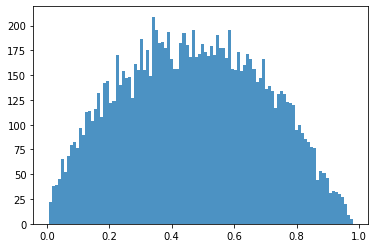

In [19]:
# スコア分布
plt.figure()
plt.hist(advval_oof_train, alpha=.8, bins=100)
plt.show()

In [20]:
advval_oof_train = pd.DataFrame({'oof_train': advval_oof_train, 'y': advval_train_y})
advval_oof_train

,oof_train,y
0,0.535892,1.0
1,0.253594,1.0
2,0.532726,1.0
3,0.596261,1.0
4,0.839055,1.0
...,...,...
7532,0.092254,0.0
7533,0.171198,0.0
7534,0.396426,0.0
7535,0.280104,0.0


In [21]:
# 訓練データのうちテストデータに近いサンプルを抽出
advval_oof_train.query('oof_train < 0.5 & y == 1')

,oof_train,y
1,0.253594,1.0
6,0.453026,1.0
7,0.181395,1.0
8,0.303109,1.0
12,0.416039,1.0
...,...,...
4980,0.445914,1.0
4982,0.445110,1.0
4983,0.092041,1.0
4984,0.299201,1.0


In [22]:
advval_train_idx = advval_oof_train.query('oof_train < 0.5 & y == 1').index
print(len(advval_train_idx))

1287


In [23]:
wiki

,id,text,toxic,text_clean,word_size
0,e617e2489abe9bca,"""\r\n\r\n A barnstar for you! \r\n\r\n The De...",False,barnstar defend wiki barnstar like edit page l...,129
1,9250cf637294e09d,"""\r\n\r\nThis seems unbalanced. whatever I ha...",False,unbalanc said mathsci said far extrem unpleas ...,457
2,ce1aa4592d5240ca,"Marya Dzmitruk was born in Minsk, Belarus in M...",False,born march mother born father born second chil...,799
3,48105766ff7f075b,"""\r\n\r\nTalkback\r\n\r\n Dear Celestia... """,False,talkback dear,13
4,0543d4f82e5470b6,New Categories \r\n\r\nI honestly think that w...,False,new categori honestli think need add categori ...,190
...,...,...,...,...,...
4995,60229df7b48ba6ff,"""\r\n\r\n Dildo, if you read my response corre...",False,dildo read respons correctli said go accus van...,221
4996,36a645227572ec5c,"CALM DOWN, CALM DOWN, DON'T GET A BIG DICK",True,calm calm dont big dick,23
4997,6d47fa39945ed6f5,In my opinion Dougweller is using his privileg...,False,opinion dougwel use privileg poorli person att...,90
4998,de2e4c0d38db6e30,The style section has been expanded too. I did...,False,style section expand didnt rememb place tag,43


In [24]:
# preparing main training data
main_train_X = wiki.iloc[advval_train_idx]['text_clean']
main_train_y = wiki.iloc[advval_train_idx]['toxic'].astype(int)
main_valid_less_X = valid['less_toxic_clean']
main_valid_more_X = valid['more_toxic_clean']

print(f'main_train_X shape: {advval_train_X.shape}')
print(f'main_train_y shape: {advval_train_y.shape}')
print(f'main_valid_less_X shape: {main_valid_less_X.shape}')
print(f'main_valid_more_X shape: {main_valid_more_X.shape}')

main_train_X shape: (12525,)
main_train_y shape: (12525,)
main_valid_less_X shape: (30108,)
main_valid_more_X shape: (30108,)


In [25]:
# 特徴抽出
print(f'feature extracting ...')
main_tfidf = TfidfVectorizer(
    stop_words=stop_words,
    min_df=3,
    max_df=0.5, 
    max_features=100_000,
    analyzer='word',
    ngram_range=(1, 1)
)

main_train_X_tfidf = main_tfidf.fit_transform(main_train_X)
main_train_X_tfidf_feature_names = main_tfidf.get_feature_names()
main_train_X_tfidf_vocab = main_tfidf.vocabulary_
main_valid_less_X_tfidf = main_tfidf.transform(main_valid_less_X)
main_valid_more_X_tfidf = main_tfidf.transform(main_valid_more_X)

print('Total number of features:', main_train_X_tfidf.shape[1])

feature extracting ...
Total number of features: 1667


In [26]:
# idf ranking
idf = {'word': main_tfidf.get_feature_names(), 'weight': main_tfidf.idf_}
pd.DataFrame(idf).sort_values('weight', ascending=False).head(10)

,word,weight
1108,politician,6.774552
464,east,6.774552
1086,photo,6.774552
455,dublin,6.774552
274,cold,6.774552
1096,planet,6.774552
270,club,6.774552
458,dumbass,6.774552
1101,plot,6.774552
1103,pointless,6.774552


In [27]:
# main
def main_training(train_X, train_y, tfidf):

    models = []
    oof_train = np.zeros((train_X.shape[0],))
    scores = []

    kf = KFold(
        n_splits=N_SPLITS, 
        shuffle=True,
        random_state=None
    )

    # 交差検証
    for fold_id, (train_idx, valid_idx) in enumerate(kf.split(train_X, train_y)):
        start = time.time()
        print(f'* ' * 40)
        print(f'fold_id: {fold_id}')

        # 訓練データ、評価データ、テストデータを整形
        print(f'preprocessing ...')
        X_trn = train_X.iloc[train_idx].reset_index(drop=True)
        X_val = train_X.iloc[valid_idx].reset_index(drop=True)
        y_trn = train_y.iloc[train_idx].reset_index(drop=True)
        y_val = train_y.iloc[valid_idx].reset_index(drop=True)

        X_trn_tfidf = tfidf.transform(X_trn)
        X_val_tfidf = tfidf.transform(X_val)

        print('Total number of train samples:', X_trn_tfidf.shape[0])
        print('Total number of valid samples:', X_val_tfidf.shape[0])

        # 訓練
        print(f'training ...')
        clf = MultinomialNB()
        clf.fit(X_trn_tfidf, y_trn)

        # 推論
        print(f'predicting ...')
        val_pred = clf.predict_proba(X_val_tfidf)[:, 1]
        oof_train[valid_idx] = val_pred
        models.append(clf)

        # 評価
        print(f'validation ...')
        score_auc = roc_auc_score(y_val, val_pred)
        scores.append(score_auc)
        elapsed = time.time() - start
        print(f'fold {fold_id} - score: {score_auc:.6f}, elapsed time: {elapsed:.2f} [sec]')

    print(f'* ' * 40)
    print(f'Average AUC: {sum(scores)/N_SPLITS:.6f}')
    
    return oof_train, models

In [28]:
%%time
main_oof_train, main_models = main_training(main_train_X, main_train_y, main_tfidf)

* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
fold_id: 0
preprocessing ...
Total number of train samples: 1029
Total number of valid samples: 258
training ...
predicting ...
validation ...
fold 0 - score: 0.847041, elapsed time: 0.04 [sec]
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
fold_id: 1
preprocessing ...
Total number of train samples: 1029
Total number of valid samples: 258
training ...
predicting ...
validation ...
fold 1 - score: 0.899691, elapsed time: 0.04 [sec]
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
fold_id: 2
preprocessing ...
Total number of train samples: 1030
Total number of valid samples: 257
training ...
predicting ...
validation ...
fold 2 - score: 0.853395, elapsed time: 0.04 [sec]
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
fold_id: 3
preprocessing ...
Total number of train samples: 1030
Total number of valid samples

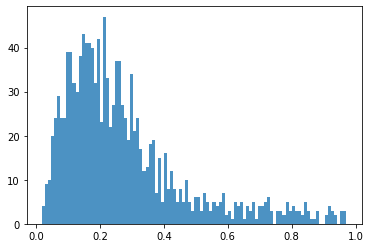

In [29]:
# スコア分布
plt.figure()
plt.hist(main_oof_train, alpha=.8, bins=100)
plt.show()

In [30]:
# adversarial validation によりテストデータに近い評価データを作成
advval_score_valid_less_toxic = np.array([clf.predict_proba(advval_valid_less_X_tfidf)[:, 1] for clf in advval_models]).sum(axis=0) / N_SPLITS
advval_score_valid_more_toxic = np.array([clf.predict_proba(advval_valid_more_X_tfidf)[:, 1] for clf in advval_models]).sum(axis=0) / N_SPLITS

test_like_valid_idx = (advval_score_valid_less_toxic < 0.5) & (advval_score_valid_more_toxic < 0.5)
print(sum(test_like_valid_idx), '/', len(test_like_valid_idx))

18799 / 30108


In [31]:
# validation score
preds_less_toxic = np.array([clf.predict_proba(main_valid_less_X_tfidf[test_like_valid_idx])[:, 1] for clf in main_models]).sum(axis=0)
preds_more_toxic = np.array([clf.predict_proba(main_valid_more_X_tfidf[test_like_valid_idx])[:, 1] for clf in main_models]).sum(axis=0)

print(f'{(preds_less_toxic < preds_more_toxic).mean():.6f}')

0.668919


In [32]:
test_X_tfidf = main_tfidf.transform(test['text_clean'])
preds_test = np.array([clf.predict_proba(test_X_tfidf)[:, 1] for clf in main_models]).sum(axis=0) / N_SPLITS
submission['score'] = preds_test

pd.DataFrame(pd.Series(submission['score'].ravel()).describe()).transpose()

,count,mean,std,min,25%,50%,75%,max
0,7537.0,0.296468,0.217014,0.010645,0.140411,0.22931,0.384966,0.983911


In [33]:
submission.to_csv('submission.csv', index=False)
submission

,comment_id,score
0,114890,0.049381
1,732895,0.131463
2,1139051,0.139107
3,1434512,0.142202
4,2084821,0.400246
...,...,...
7532,504235362,0.114169
7533,504235566,0.082823
7534,504308177,0.065223
7535,504570375,0.437727
